<a href="https://colab.research.google.com/github/Meghanxuxx/Compiler-Project/blob/main/ECE1724_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group Member:
Yuming Li, Haocheng Yang, Huilin Xu
### **Part1 Data Preparation**
The goal of our program is to provide the fastest way to get students to school by assigning them to the bus stop closest to their home and sending school buses to pick them up and drop them off. Our data comes from overpass and focuses on Toronto, North York within 2500 meters. The main data collected includes

**1. schools**

**2. residences**

**3. bus stops**

Specific reasons for choosing a smaller range at this time include the fact that we need to take into account the time window in which students go to school, so we have temporarily narrowed down the range to be on the safe side to ensure that the number of students is small. If the algorithm performs well in subsequent results, we will gradually expand the range to be considered.

In [ ]:
!pip install overpass
import requests
import overpass
overpass_url = "https://overpass-api.de/api/interpreter"

api = overpass.API()

# Find the data of residence
residential_query = """
[out:json][timeout:50];
area[place=city]["name:en"="Toronto"]->.searchArea;
(
 node["landuse"="residential"](area.searchArea)(around:2500,43.7695, -79.4061);
 way["landuse"="residential"](area.searchArea)(around:2500,43.7695, -79.4061);
 relation["landuse"="residential"](area.searchArea)(around:2500,43.7695, -79.4061);
);
out center;
"""

residence_response = requests.get(overpass_url, params={"data": residential_query})

if residence_response.status_code == 200:
    residential_data = residence_response.json()
else:
    print("Failed:", residence_response.status_code)

# Find the data fo school
school_query = """
[out:json][timeout:50];
area[place=city]["name:en"="Toronto"]->.searchArea;
map_to_area;
(
  node["amenity"="school"](around:1500,43.7695, -79.4061);
  way["amenity"="school"](around:1500,43.7695, -79.4061);
  rel["amenity"="school"](around:1500,43.7695, -79.4061);
);
out center;

"""

school_response = requests.get(overpass_url, params={"data": school_query})
if school_response.status_code == 200:
    schools_data = school_response.json()

# Find the data of Bus Stop
bus_stop_query = """
[out:json][timeout:50];
area[place=city]["name:en"="Toronto"]->.searchArea;
map_to_area;
(
area[place=city]["name:en"="Toronto"]->.searchArea;
node["highway"="bus_stop"](area.searchArea)(around:2500,43.7695, -79.4061);
way["highway"="bus_stop"](area.searchArea)(around:2500,43.7695, -79.4061);
relation["highway"="bus_stop"](area.searchArea)(around:2500,43.7695, -79.4061);
);
out center;
"""

bus_stop_response = requests.get(overpass_url, params={"data": bus_stop_query})
if bus_stop_response.status_code == 200:
    bus_stop_data = bus_stop_response.json()

# Check again if the data is download correctly
response_schools = requests.get(overpass_url, params={"data": school_query})
response_bus_stops = requests.get(overpass_url, params={"data": bus_stop_query})
response_residential = requests.get(overpass_url, params={"data": residential_query})

print(response_schools.status_code)
print(response_bus_stops.status_code)
print(response_residential.status_code)

200
200
200


In [ ]:
! pip install plotly
import plotly.graph_objects as obj
import pandas as pd

# Data Cleanning
def process_data(data):
    coords = []
    name = []
    for elem in data['elements']:
        lat = None
        lon = None
        # Check if 'lat' and 'lon' does exist
        if "lat" in elem and "lon" in elem:
            lat = elem["lat"]
            lon = elem["lon"]
        elif 'center' in elem:
            lat = elem["center"]["lat"]
            lon = elem["center"]["lon"]
        # If exist, append
        if lat and lon:
            coords.append((lon, lat))
        # check if name exist
        if 'tags' in elem and 'name' in elem['tags']:
            name.append(elem['tags']['name'])
        else:
            name.append('NONAME')
    return coords, name

school_coords, school_names = process_data(schools_data)
bus_stop_coords, bus_stop_name = process_data(bus_stop_data)
residential_coords, residential_name = process_data(residential_data)

# Figure for all the schools, bus stops and residence
fig = obj.Figure()

fig.add_trace(obj.Scattermapbox(
    lat=[x[1] for x in school_coords],
    lon=[x[0] for x in school_coords],
    mode='markers',
    marker=dict(size=8, color='#EDB120'),
    name='Schools',
    hoverinfo='text'
))

fig.add_trace(obj.Scattermapbox(
    lat=[x[1] for x in bus_stop_coords],
    lon=[x[0] for x in bus_stop_coords],
    mode='markers',
    marker=dict(size=8, color='blue'),
    name='Bus Stops',
    hoverinfo='text'
))

fig.add_trace(obj.Scattermapbox(
    lat=[x[1] for x in residential_coords],
    lon=[x[0] for x in residential_coords],
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Residences',
    hoverinfo='text'
))

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': 43.7695, 'lon': -79.4061}, 'zoom': 13}
)

fig.show()


### **Part2 Use KNN to assign bus stops and schools**

KNN as supervised learning for classification perfectly fulfills the purpose of assigning students the nearest bus stops as well as schools to their homes. The reason why we want to assign schools to students is because we cannot get information about every student's school attendance. In order to ensure the completeness and rigor of the data, we chose to select the nearest school to home for the students.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Put data into the dataframe
residential_df = pd.DataFrame(residential_coords, columns=['Longitude', 'Latitude'])
school_coords_df = pd.DataFrame(school_coords, columns=['Longitude', 'Latitude'])
school_coords_df["Name"] = school_names

# It is not likely we can get information about the schooling of the children in the residence,
# so we assume that they attend school close to home
# Using Knn to allocation schools to children in residential near their homes
# We set n_neighbors to 1 becasue every kids only go to 1 school
knn = NearestNeighbors(n_neighbors=1)
knn.fit(school_coords_df[['Longitude', 'Latitude']])

# Find school that is closet to the residence
num, num1 = knn.kneighbors(residential_df[['Longitude', 'Latitude']])

# Complete residential_df dataframe
residential_df['Nearest_School'] = num1[:, 0]
residential_df['School'] = residential_df['Nearest_School'].apply(lambda x: school_names[x])
residential_df['School_Lon'] = residential_df['Nearest_School'].apply(lambda x: school_coords_df.iloc[x]['Longitude'])
residential_df['School_Lat'] = residential_df['Nearest_School'].apply(lambda x: school_coords_df.iloc[x]['Latitude'])

# We assume half the residients have kids to go to school, so random drop half the residence
residential_half = residential_df.sample(frac=0.5, random_state=1)

bus_stop_coords = pd.DataFrame(bus_stop_coords, columns=['Longitude', 'Latitude'])


Below is the visualization code and result for half of the residential places

In [ ]:
import plotly.express as px
center = (43.7695, -79.4061)

# use density_mapbox to create density_mapbox
fig = px.density_mapbox(
    data_frame=residential_half,
    lat=residential_half['Latitude'],
    lon=residential_half['Longitude'],
    radius=5,
)

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 10}
)
fig.show()

In [ ]:
center = (43.7695, -79.4061)
import plotly.figure_factory as ff
# use create_hexbin_mapbox to create Hexbin Mapbox
fig = ff.create_hexbin_mapbox(
    data_frame=residential_half,
    lat=residential_half['Latitude'],
    lon=residential_half['Longitude'],
    nx_hexagon=10,
    opacity=0.5,
    min_count=1,
    labels={'color': 'Residence Number'},
    color_continuous_scale='turbo'
)

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 10}
)
fig.show()


In [ ]:
# We again used knn to find the nearest bus stop of each residence
knn = NearestNeighbors(n_neighbors=1)
knn.fit(bus_stop_coords[['Latitude', 'Longitude']])
num, num1 = knn.kneighbors(residential_half[['Latitude', 'Longitude']])

# Complete residential_df dataframe
residential_half['Nearest_Bus_Stop'] = num1.flatten()
residential_half['Nearest_Bus_Stop_Lat'] = residential_half['Nearest_Bus_Stop'].apply(lambda x: bus_stop_coords.loc[x, 'Latitude'])
residential_half['Nearest_Bus_Stop_Lon'] = residential_half['Nearest_Bus_Stop'].apply(lambda x: bus_stop_coords.loc[x, 'Longitude'])


In [ ]:
# Add a colunm for bus_stop_coords, how many people are waiting at each bus stop
stop_count =  residential_half['Nearest_Bus_Stop'].value_counts()
bus_stop_coords["Num People"] = 0
for i in bus_stop_coords.index:
  if i in stop_count.index:
    bus_stop_coords.loc[i, "Num People"] = stop_count[i]

In [ ]:
# Picture showing the relationship between residential and bus stop allocations
fig = obj.Figure()

marker1 = obj.scattermapbox.Marker(size=10, color='blue')
fig.add_trace(obj.Scattermapbox(
    lat=residential_half['Latitude'],
    lon=residential_half['Longitude'],
    mode='markers',
    marker=marker1,
    name='residence'
))

marker2 = obj.scattermapbox.Marker(size=10, color='red')
fig.add_trace(obj.Scattermapbox(
    lat=residential_half['Nearest_Bus_Stop_Lat'],
    lon=residential_half['Nearest_Bus_Stop_Lon'],
    mode='markers',
    marker=marker2,
    name='Bus Stops'
))

for i, j in residential_half.iterrows():
    fig.add_trace(obj.Scattermapbox(
        lat=[j['Latitude'], j['Nearest_Bus_Stop_Lat']],
        lon=[j['Longitude'], j['Nearest_Bus_Stop_Lon']],
        mode='lines',
        line=dict(width=1, color='gray')
    ))

lat1 = residential_half['Latitude'].mean()
lon1 = residential_half['Longitude'].mean()
fig.update_layout(
    mapbox_style="stamen-terrain",
    mapbox_zoom=10,
    mapbox_center={"lat": lat1, "lon": lon1},
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.show()


In [ ]:
# Picture showing the relationship between residential and school allocations

school_df = pd.DataFrame({
    'Longitude': school_coords_df['Longitude'],
    'Latitude': school_coords_df['Latitude'],
    'Name': school_names[:len(school_coords)]
})

chosen_bus_stops_df = residential_half[['Nearest_Bus_Stop_Lat', 'Nearest_Bus_Stop_Lon', 'School', 'Nearest_Bus_Stop']]

fig = obj.Figure()

fig.add_trace(obj.Scattermapbox(
    lat=school_df['Latitude'],
    lon=school_df['Longitude'],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='school',
    text=school_df['Name']
))

fig.add_trace(obj.Scattermapbox(
    lat=residential_df['Latitude'],
    lon=residential_df['Longitude'],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='residence'
))

for i, j in residential_df.iterrows():
    fig.add_trace(obj.Scattermapbox(
            lat = [j['Latitude'], j['School_Lat']],
            lon = [j['Longitude'], j['School_Lon']],
            mode = 'lines',
            line = dict(width = 1, color = 'gray'),
            name='relation'
        )
    )

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': 43.7695, 'lon': -79.4061}, 'zoom': 13}
)

fig.show()


Below is the bubble map for bus stops, with each bubble representing a bus stop, the size of the bubble is to illustrate the number of students waiting at this bus stop

In [ ]:
! pip install folium
import folium as folium
m = folium.Map(location=[center[0],center[1]],zoom_start=10, scrollWheelZoom=True, dragging=True)

# count the times of presence of each school name
counts = [residential_half[residential_half['Nearest_Bus_Stop'] == index].shape[0] for index in chosen_bus_stops_df['Nearest_Bus_Stop']]
result = chosen_bus_stops_df[['Nearest_Bus_Stop_Lat', 'Nearest_Bus_Stop_Lon']]
result['residence_number'] = counts

for i,r in result.iterrows():
  # print(r)
  folium.Circle(
      location=[r[0],r[1]],
      radius = float(r[2])*50,
      fill=True,
      popup=f"{r[0]},{r[1]}: {r[2]}",
      color = 'blue'
      ).add_to(m)
display(m)

Below is the bubble map of schools, with each bubble representing a school, the size of the bubble is to illustrate the number of students of the particular school

In [ ]:
m = folium.Map(location=[center[0],center[1]],zoom_start=10, scrollWheelZoom=True, dragging=True)

# count the times of presence of each school name
counts = [residential_half[residential_half['Nearest_School'] == index].shape[0] for index in range(len(school_coords))]
result = pd.DataFrame(school_coords, columns=['Longitude', 'Latitude'])
result['residence_number'] = counts
result['school_name'] = school_names

for i,r in result.iterrows():
  # print(r)
  folium.Circle(
      location=[r[1],r[0]],
      radius = float(r[2])*20,
      fill=True,
      popup=f"{r[3]}: {r[2]}",
      color = 'blue'
      ).add_to(m)
display(m)

The graph below is the final point we need, we no longer need the residence and the bus stops where no students are waiting, so we remove all of this data, the
data has all been processed and we can proceed to the algorithmic section

In [ ]:
# A map of schools and bus stops, i.e., all the points school bus will end up passing through
chosen_bus_stops_df = residential_half[['Nearest_Bus_Stop_Lat', 'Nearest_Bus_Stop_Lon']]

fig = obj.Figure()
fig.add_trace(obj.Scattermapbox(
    lat=school_df['Latitude'],
    lon=school_df['Longitude'],
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Schools',
    text=school_df['Name'],
    hoverinfo='text'
))

fig.add_trace(obj.Scattermapbox(
    lat=chosen_bus_stops_df['Nearest_Bus_Stop_Lat'],
    lon=chosen_bus_stops_df['Nearest_Bus_Stop_Lon'],
    mode='markers',
    marker=dict(size=8, color='blue'),
    name='Chosen Bus Stops',
    hoverinfo='text'
))

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': 43.7695, 'lon': -79.4061}, 'zoom': 13}
)

fig.show()


Below is the code and result of heat graph for the schools and chosen bus stops

In [ ]:
import plotly.express as px

# rename the chosen_bus_stops_df
chosen_bus_stops_df = chosen_bus_stops_df.rename(columns={'Nearest_Bus_Stop_Lat': 'Latitude', 'Nearest_Bus_Stop_Lon': 'Longitude'})
# switch the columns
chosen_bus_stops_df = chosen_bus_stops_df[['Longitude', 'Latitude']]
# concatch the two dataFrames
result = pd.concat([school_df, chosen_bus_stops_df])
# use density_mapbox to create density_mapbox
fig = px.density_mapbox(
    data_frame=result,
    lat=result['Latitude'],
    lon=result['Longitude'],
    radius=5,
)

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 10}
)
fig.show()

Below is the hexagonal binning map for chosen bus stops and schools

In [ ]:
# use create_hexbin_mapbox to create Hexbin Mapbox
fig = ff.create_hexbin_mapbox(
    data_frame=result,
    lat=result['Latitude'],
    lon=result['Longitude'],
    nx_hexagon=10,
    opacity=0.5,
    min_count=1,
    labels={'color': 'interested points'},
    color_continuous_scale='turbo'
)

fig.update_layout(
    mapbox_style="stamen-terrain",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 10}
)
fig.show()

We also need to reveal the relation between the schools and the assigned bus stops, each school will have a few bus stops that are specially for its school bus to stop. Of course, only the bus stops with this school's students will become the target bus stops of this school.

In [ ]:
# create an array to store the bus stop index of each school
# we also stores the number of students of this school
# who will be waiting at the bus stop
bus_stop_array = []
for i in range(len(school_df)):
  bus_stops_for_this_school = {}
  for index, row in residential_half.iterrows():
    if row['Nearest_School'] == i:
      nearest_bus_stop = row['Nearest_Bus_Stop']
      if nearest_bus_stop in bus_stops_for_this_school:
        bus_stops_for_this_school[nearest_bus_stop] += 1
      else:
        bus_stops_for_this_school[nearest_bus_stop] = 1
  bus_stop_array.append(bus_stops_for_this_school)

Conclusions and deeper understandings gained from data visualization:
1. The hexagonal binning map and heat map of schools and chosen bus stops show that in the southwest corner of our interested area more routing points are located. If we want to district these areas, we will need higher granularity than the northeast part of our intetested area.

2. The heat map of residences shows there are more residences in the south part of our area, however, the schools and bus stops are distributed evenly, so it is better that we plan our routes to start from the south part and end at the north. We can further examine the results generated by our algorithms by checking if the routes have the patterns mentioned above.

3. The bubble map of the assigned number of student units per bus stop shows that using our algorithm of knn, we have achieve a relatively fair distribution. Most of the chosen bus stops have 1-2 residences to serve, with only a few bus stops in the east part have 3 residences to serve. If we could inform the residents to go to the assigned bus stops, the load balancing of the whole school bus routing system will be excellent. This will also help us to minimize the influence of bus capacity on the choice of routes.

4. The bubble map of the assigned number of student units per school shows that knn with a judgement factor of distance between the residence and the school is rather unfair in assigning students to schools. We have the St. Gabriel Catholic School having almost half of the students in this area. However, based on what we have found on Toronto Distric School Board, there is no big fluctuations in the number of students between schools, most schools have 1-200 students.

5. We have visualized the distribution of traffic accidents in our previous work, and this will also become a important factor in our decision making process. We now plan to sum up the number of traffic accidents for every block that is on the route to gain a safety factor that will later serve as a constraint to help us drop infeasible solutions.

### **Part3 Algorithm**

In [ ]:
# here we define a function that helps us to trim the path we find
# to meet the capacity constraint of the school bus

# define the school bus capacity
C = 11

'''
  path: the array that stores a sequence of bus stop index, it is an array of numbers
  school_index: the index of the school to which this path belongs to
  note that the returned path does not include the school
'''
def trim_path(path, school_index, bus_stop_array_copy):
  # exclude the final element which is the start point
  if len(path) == 0:
   return []
  path = path[1:len(path)-1]
  # print(path)
  # the cumulative student number on the bus
  stu_num = 0
  idx = 0
  # the dictionary that stores the number of students at each stop
  stu_stop_dict = bus_stop_array_copy[school_index]
  for node in path:
    stu_num += stu_stop_dict[node]
    stu_stop_dict[node] = 0
    if stu_num >= C:
      stu_stop_dict[node] += (stu_num - C)
      return path[:idx+1]
    else:
      idx += 1
  return path

In [ ]:
# test the function of the trim function
# where 11 is temporarily the school

bus_stop_array = [{188: 1, 25: 2, 189: 2},
 {145: 2, 2: 1, 62: 1, 170: 3, 172: 1, 96: 1, 169: 1, 97: 1},
 {78: 1, 201: 1},
 {54: 3, 232: 3, 188: 2, 207: 1, 187: 1, 175: 1, 52: 1},
 {182: 1, 63: 1, 73: 1},
 {43: 2, 222: 3, 39: 2, 231: 2, 194: 1, 40: 1, 71: 1, 42: 1, 23: 1, 36: 1},
 {132: 3,
  2: 5,
  134: 1,
  70: 3,
  3: 5,
  0: 2,
  1: 4,
  72: 3,
  9: 3,
  131: 1,
  133: 1,
  5: 1,
  4: 1},
 {27: 1},
 {},
 {245: 1, 121: 1},
 {254: 1, 177: 1},
 {164: 1, 178: 1},
 {}]
# path = [0, 70, 131, 132, 133, 72, 9, 0, 1, 2, 3, 4, 5, 134, 0]
# path = []
# print(bus_stop_array[6])
# path = trim_path(path, 6)
# print(bus_stop_array[6])
# print(path)

**Library preparation**

To avoid repeat of library import, we import the needed library resources here.

In [ ]:
!pip install haversine
!pip install pymoo
!pip install minisom
!pip install osmnx
!pip install optalgotools
!pip install pyproj
!pip install aco
from collections import defaultdict
from haversine import haversine
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize
from minisom import MiniSom
import networkx as nx
import osmnx as ox
import time
import copy
from optalgotools.structures import Node
from optalgotools.routing import cost, draw_route
from optalgotools.algorithms.graph_search import Dijkstra
from optalgotools.problems import TSP
from optalgotools.algorithms import SimulatedAnnealing
from pyproj import Transformer
from aco import AntColony

**SA Algorithm**

In [ ]:
def eval_distances_from_stops(stops):
    n = len(stops)
    dists = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            dist = haversine(stops[i], stops[j])
            dists[i][j] = dist
            dists[j][i] = dist
    return dists

In [ ]:
bus_stop_array_copy = copy.deepcopy(bus_stop_array)
found_path_sa = []

for i in range(len(school_df)):
    school_data = school_df.iloc[i]
    bus_stop_indices = list(bus_stop_array_copy[i].keys())

    if len(bus_stop_indices) == 0:
        found_path_sa.append([])
        continue

    stop_points = [[school_data['Latitude'], school_data['Longitude']]]
    stop_names = [school_data['Name']]

    for k in bus_stop_indices:
        bus_stop_data = bus_stop_coords.iloc[k]
        stop_points.append([bus_stop_data['Latitude'], bus_stop_data['Longitude']])
        stop_names.append('bus stop ' + str(k))

    best_order, time_spent = run_sa_for_school(stop_points)

    if best_order is None:
        found_path_sa.append([])
        continue

    best_order_names = [stop_names[idx] for idx in best_order]
    trimmed_order = trim_path(best_order_names, i, bus_stop_array_copy)

    school_name = school_df.iloc[i]['Name']
    complete_route = [school_name] + trimmed_order + [school_name]
    found_path_sa.append([complete_route])

    bus_stop_array_copy[i] = {key: value for key, value in bus_stop_array_copy[i].items() if value != 0}

print(found_path_sa)

**Particle Swarm Optimization**

**Genetic Algorithm**

preparation of some utility class

In [ ]:
# create the problem class
class TravelingSalesman(ElementwiseProblem):

    def __init__(self, cities, distances, **kwargs):
        self.cities = cities
        n_cities = len(cities)
        self.distances = distances

        super().__init__(
            n_var=n_cities,
            n_obj=1,
            xl=0,
            xu=n_cities,
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f = 0
        for i in range(len(x) - 1):
            f += distances[x[i], x[i + 1]]
        f += distances[x[-1], x[0]]
        out["F"] = f

In [ ]:
# ensure each solution starts from the city with index 0
class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X

use GA to solve the problem

In [ ]:
bus_stop_array_copy = copy.deepcopy(bus_stop_array)
# search path for all schools
found_path = [[] for _ in range(len(school_df))]
i = 0
while i < len(school_df):
  # generate the "cities" for this particular school
  cities = {}
  cities['school'] = (school_df.loc[i]['Latitude'], school_df.loc[i]['Longitude'])
  bus_stop_index = list(bus_stop_array_copy[i].keys())
  # skip the schools without bus stops
  if len(bus_stop_index) == 0:
    i += 1
    continue
  for a_bus_idx in bus_stop_index:
    cities[a_bus_idx] = (bus_stop_coords.loc[a_bus_idx]['Latitude'], bus_stop_coords.loc[a_bus_idx]['Longitude'])
  # create a two-dimension matrix, with distance_matrix[ka][kb] reffering to the distance between cities with
  # the index of ka and kb
  distance_matrix = defaultdict(dict)
  for ka, va in cities.items():
      for kb, vb in cities.items():
          distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1]))

  # Convert distance dictionary into a dataframe
  distances = pd.DataFrame(distance_matrix)
  city_names=list(distances.columns)
  distances=distances.values
  # define the problem and the GA solver
  problem = TravelingSalesman(cities,distance_matrix)

  algorithm = GA(
      pop_size=20,
      sampling=PermutationRandomSampling(),
      mutation=InversionMutation(),
      crossover=OrderCrossover(),
      repair=StartFromZeroRepair(),
      eliminate_duplicates=True
  )

  # set the termination condition: if the result does not improve in 300 generations, then terminate
  termination = DefaultSingleObjectiveTermination(period=300, n_max_gen=np.inf)

  # use pymoo to solve the problem
  # start = time.time()
  res = minimize(
      problem,
      algorithm,
      termination,
      seed=1,
      verbose=False
  )

  # end = time.time()
  # print the route and the length
  Order = res.X
  Order = list(Order)
  Order.append(0)

  # turn the relative order to a absolute order, aka use the bus stop index rather than the number that represents its order
  for it in range(1,len(Order)-1):
    Order[it] = city_names[Order[it]]
  #trim the generated path
  Order = trim_path(Order, i, bus_stop_array_copy)
  # complete the path
  Order.insert(0,school_df.iloc[i]['Name'])
  Order.append(school_df.iloc[i]['Name'])

  found_path[i].append(Order)
  # delete those bus stops where no student is waiting
  bus_stop_array_copy[i] = {key: value for key, value in bus_stop_array_copy[i].items() if value != 0}
  # if there is any student who is waiting, keep searching
  if len(bus_stop_array_copy[i]) == 0:
    i += 1

found_path

[[['Toronto Central Academy', 188, 189, 25, 'Toronto Central Academy']],
 [['Royal Crown Academic School',
   145,
   170,
   2,
   62,
   169,
   172,
   96,
   97,
   'Royal Crown Academic School']],
 [['FutureSkills High School', 201, 78, 'FutureSkills High School']],
 [['Avondale Alternative Elementary School',
   188,
   187,
   52,
   175,
   232,
   207,
   54,
   'Avondale Alternative Elementary School'],
  ['Avondale Alternative Elementary School',
   54,
   'Avondale Alternative Elementary School']],
 [['Shining Through Centre', 63, 73, 182, 'Shining Through Centre']],
 [['Avondale Public School',
   23,
   43,
   42,
   40,
   39,
   71,
   194,
   222,
   'Avondale Public School'],
  ['Avondale Public School', 36, 222, 231, 'Avondale Public School']],
 [['St. Gabriel Catholic School',
   70,
   131,
   132,
   133,
   72,
   'St. Gabriel Catholic School'],
  ['St. Gabriel Catholic School', 9, 0, 1, 2, 'St. Gabriel Catholic School'],
  ['St. Gabriel Catholic School',
   5,
 

['Toronto Central Academy', 188, 189, 25, 'Toronto Central Academy']
['Royal Crown Academic School', 145, 170, 2, 62, 169, 172, 96, 97, 'Royal Crown Academic School']
['FutureSkills High School', 201, 78, 'FutureSkills High School']
['Avondale Alternative Elementary School', 188, 187, 52, 175, 232, 207, 54, 'Avondale Alternative Elementary School']
['Avondale Alternative Elementary School', 54, 'Avondale Alternative Elementary School']
['Shining Through Centre', 63, 73, 182, 'Shining Through Centre']
['Avondale Public School', 23, 43, 42, 40, 39, 71, 194, 222, 'Avondale Public School']
['Avondale Public School', 36, 222, 231, 'Avondale Public School']
['St. Gabriel Catholic School', 70, 131, 132, 133, 72, 'St. Gabriel Catholic School']
['St. Gabriel Catholic School', 9, 0, 1, 2, 'St. Gabriel Catholic School']
['St. Gabriel Catholic School', 5, 4, 3, 2, 134, 'St. Gabriel Catholic School']
['Hollywood Public School', 27, 'Hollywood Public School']
['McKee Public School', 245, 121, 'McKee

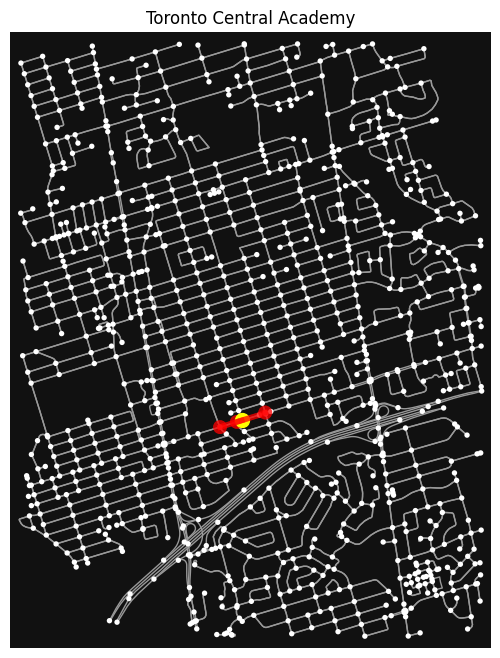

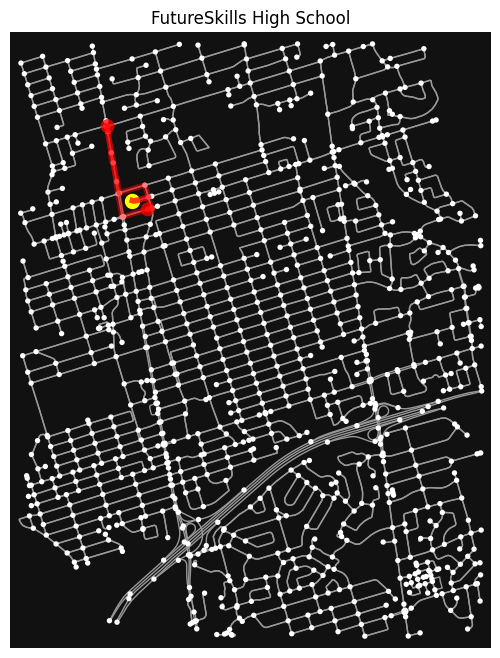

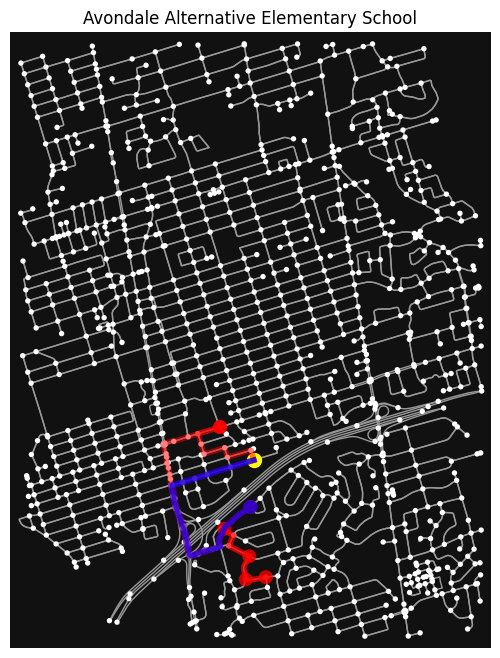

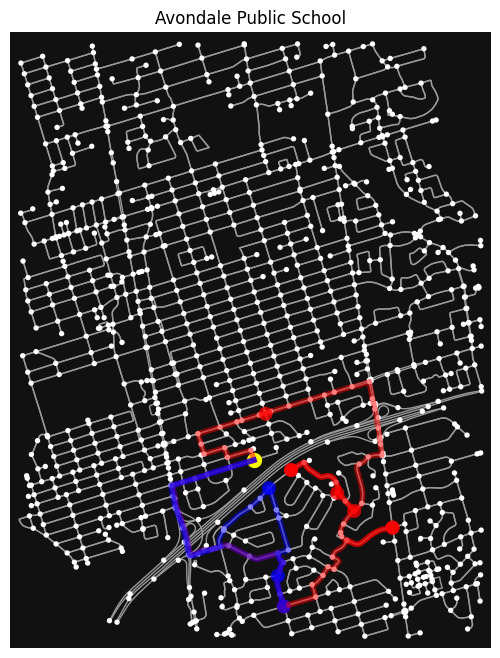

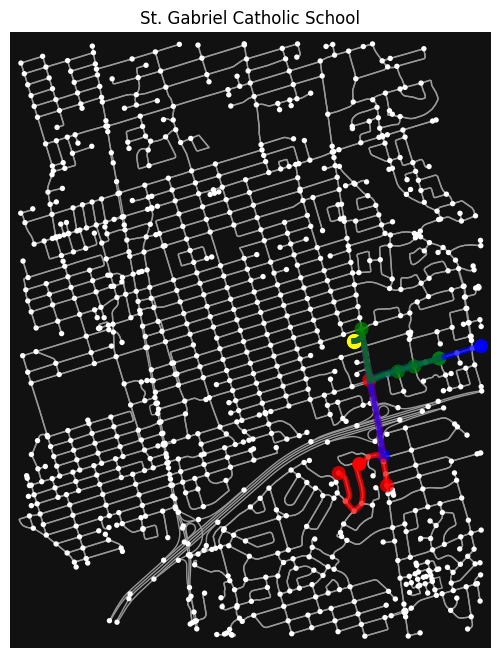

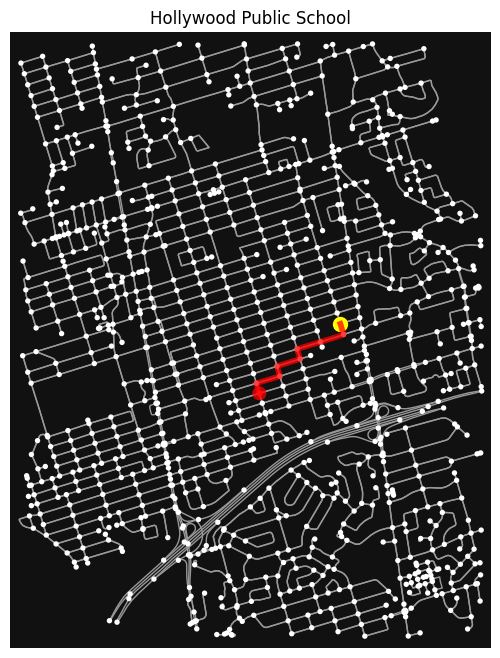

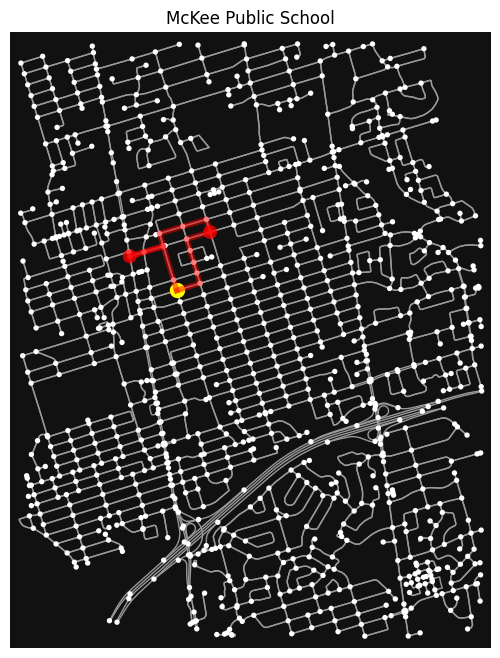

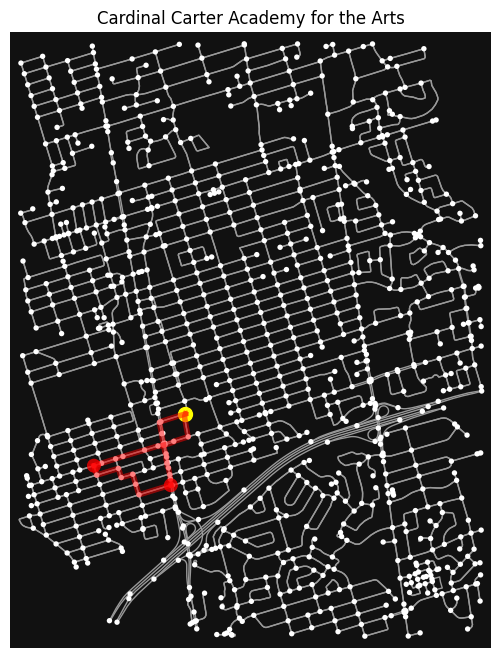

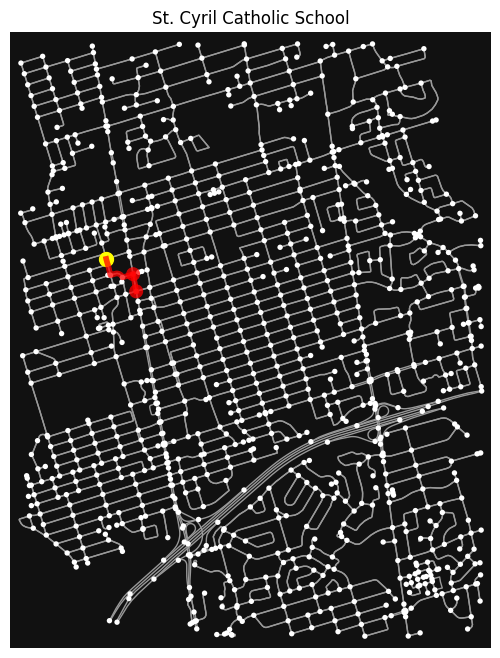

In [ ]:
# Create a graph
edge1 = residential_half['Latitude'].max()
edge2 = residential_half['Latitude'].min()
edge3 = residential_half['Longitude'].max()
edge4 = residential_half['Longitude'].min()

graph = ox.graph_from_bbox(edge1, edge2, edge3, edge4, network_type='drive')
colors = ['r', 'b', 'g', 'cyan']
for path in found_path:
  if len(path) != 0:
    # One figure per school
    fig, ax = ox.plot_graph(graph, show=False, close=False)
    for sub_path_index in range(len(path)):
      print(path[sub_path_index])
      nearest_nodes = find_nearest_node(graph, path[sub_path_index])
      i = 0
      for i in range(len(nearest_nodes)-1):
        unrelaxed_nodes = [Node(graph, osmid) for osmid in graph.nodes()]
        origin = Node(graph=graph, osmid=nearest_nodes[i])
        destination = Node(graph=graph, osmid=nearest_nodes[i+1])
        solution_Dijkstra = Dijkstra(origin, destination, unrelaxed_nodes)
        # Different bus routes from the same school are with different colors
        ox.plot_graph_route(graph, solution_Dijkstra.result, route_color=colors[sub_path_index], orig_dest_size=100, ax=ax, show=False, close=False)
    # mark the start point (school) with yellow
    ax.scatter(graph.nodes[nearest_nodes[0]]['x'], graph.nodes[nearest_nodes[0]]['y'], c='yellow', s=100)
    ax.set_title(path[0][0])

**ACO**

In [ ]:
# convert the original longitude and latitude geo information to cartesian coords
'''
  lat_and_long: the latitude and longitude information of all destination points of one school
'''
def cartesian_coords(lat_and_long):
  cartesian = []
  for a_latlong in lat_and_long:
    long = a_latlong[0]
    lat = a_latlong[1]
    # define the coord system
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3395")
    # convert to cartesian
    x, y = transformer.transform(long, lat)
    cartesian.append((x,y))
  return cartesian

use ACO to solve the problem

In [ ]:
bus_stop_array_copy = copy.deepcopy(bus_stop_array)
# search path for all schools
found_path_aco = [[] for _ in range(len(school_df))]
i = 0
while i < len(school_df):
  # generate the "cities" for this particular school
  cities = []
  cities.append((school_df.loc[i]['Longitude'], school_df.loc[i]['Latitude']))
  bus_stop_index = list(bus_stop_array_copy[i].keys())
  # skip the schools without bus stops
  # if len(bus_stop_index) == 0:
  #   i += 1
  #   continue
  for a_bus_idx in bus_stop_index:
    cities.append((bus_stop_coords.loc[a_bus_idx]['Longitude'], bus_stop_coords.loc[a_bus_idx]['Latitude']))

  # record the cities' names
  bus_stop_index.insert(0, 'school')
  # use ACO to solve the problem
  cartesian = cartesian_coords(cities)
  # regularize the data
  for cc in range(len(cartesian)):
    cartesian[cc] = (cartesian[cc][0]-4870000, cartesian[cc][1]+15100000)
  print(cartesian)
  colony = AntColony(cartesian, start = cartesian[0], iterations = 1)

  # print the result
  # best_seen_path = colony.get_path()
  # print(best_seen_path)
  i+=1
  # # print the route and the length
  # Order = res.X
  # Order = list(Order)
  # Order.append(0)

  # # turn the relative order to a absolute order, aka use the bus stop index rather than the number that represents its order
  # for it in range(1,len(Order)-1):
  #   Order[it] = bus_stop_index[Order[it]]
  # #trim the generated path
  # Order = trim_path(Order, i, bus_stop_array_copy)
  # # complete the path
  # Order.insert(0,school_df.iloc[i]['Name'])
  # Order.append(school_df.iloc[i]['Name'])

  # found_path_aco[i].append(Order)
  # # delete those bus stops where no student is waiting
  # bus_stop_array_copy[i] = {key: value for key, value in bus_stop_array_copy[i].items() if value != 0}
  # # if there is any student who is waiting, keep searching
  # if len(bus_stop_array_copy[i]) == 0:
  #   i += 1

found_path_aco

**SOM**

In [ ]:
bus_stop_array_copy = copy.deepcopy(bus_stop_array) # avoid directly modified bus_stop_array
found_path_som = [[] for _ in range(len(school_df))]
i = 0
while i < len(school_df):
  stop_points = [[school_df.iloc[i]['Latitude'], school_df.iloc[i]['Longitude']]]
  bus_stop_index = list(bus_stop_array_copy[i].keys())

  # skip the schools without bus stops
  if len(bus_stop_index) == 0:
    i += 1
    continue

  pathway_name = []
  stop_name = [school_df.iloc[i]['Name']]
  for k in bus_stop_index:
    stop_points.append([bus_stop_coords.iloc[k]['Latitude'], bus_stop_coords.iloc[k]['Longitude']])
    stop_name.append('bus stop '+str(k))
    pathway_name.append(k)

  stop_count = len(stop_points)
  N_neurons = stop_count*2
  iteration = 2000
  start = time.time()

  # Create a self-organizing map with 1xN_neurons grid
  som = MiniSom(1, N_neurons, 2, sigma=10, learning_rate=.5,
                neighborhood_function='gaussian', random_seed=50)

  som.random_weights_init(stop_points)
  som.train(stop_points, iteration, verbose=False, random_order=False)
  visit_order = np.argsort([som.winner(p)[1] for p in stop_points])
  visit_order = np.concatenate((visit_order, [visit_order[0]]))
  end = time.time()

  # Rearrange the visit order to make it start from school
  visit_order = list(visit_order)
  index_0 = visit_order.index(0)
  visit_order = visit_order[index_0:-1] + visit_order[:index_0] + [0]
  visit_order_name = [-1]+[pathway_name[j-1] for j in visit_order[1:-1]]+[-1] # -1 represents the name of school
  #trim the generated path
  trim_visit_order = trim_path(visit_order_name, i, bus_stop_array_copy)

  # complete the path
  trim_visit_order.insert(0,school_df.iloc[i]['Name'])
  trim_visit_order.append(school_df.iloc[i]['Name'])
  # trim_visit_order.insert(0,-1)
  # trim_visit_order.append(-1)
  found_path_som[i].append(trim_visit_order)
  # delete those bus stops where no student is waiting
  bus_stop_array_copy[i] = {key: value for key, value in bus_stop_array_copy[i].items() if value != 0}
  # if there is any student who is waiting, keep searching
  if len(bus_stop_array_copy[i]) == 0:
    i += 1

  # stop_index_list = list(nx.utils.pairwise(visit_order))
  # stop_name_order = [stop_name_str[i] for i in visit_order]
  # route_SOM = " → ".join(stop_name_order)
  # print("Route of SOM:", route_SOM)
  # print("Time spent to generate this path {t:.3f}s".format(t=end-start))
  # i += 1
  # print(i)
found_path_som

/usr/local/lib/python3.10/dist-packages/minisom.py:162: UserWarning:




[[['Toronto Central Academy', 25, 188, 189, 'Toronto Central Academy']],
 [['Royal Crown Academic School',
   145,
   170,
   2,
   62,
   172,
   169,
   96,
   97,
   'Royal Crown Academic School']],
 [['FutureSkills High School', 78, 201, 'FutureSkills High School']],
 [['Avondale Alternative Elementary School',
   54,
   52,
   175,
   232,
   207,
   188,
   'Avondale Alternative Elementary School'],
  ['Avondale Alternative Elementary School',
   187,
   'Avondale Alternative Elementary School']],
 [['Shining Through Centre', 63, 73, 182, 'Shining Through Centre']],
 [['Avondale Public School',
   43,
   42,
   23,
   194,
   71,
   39,
   40,
   222,
   'Avondale Public School'],
  ['Avondale Public School', 36, 222, 231, 'Avondale Public School']],
 [['St. Gabriel Catholic School',
   70,
   132,
   131,
   133,
   72,
   'St. Gabriel Catholic School'],
  ['St. Gabriel Catholic School',
   134,
   9,
   5,
   4,
   2,
   'St. Gabriel Catholic School'],
  ['St. Gabriel Catholic 

In [ ]:
edge1 = residential_half['Latitude'].max()
edge2 = residential_half['Latitude'].min()
edge3 = residential_half['Longitude'].max()
edge4 = residential_half['Longitude'].min()

graph = ox.graph_from_bbox(edge1, edge2, edge3, edge4, network_type='walk')

In [ ]:
'''
  Find the nearest node to each points of the route.
  graph: graph generated by ox.graph_from_bbox() for residential area
  coord_list: the list that stores a sequence of stop points for a bus route, the start point (school) can be included
  return: nearest node IDs of the bus route
'''
def find_nearest_node(graph, coord_list):
  coord_lon = []
  coord_lat = []
  for elem in coord_list:
    if isinstance(elem, str): # the element is the name of school
      coord_lon.append(residential_half[residential_half['School']==elem]['School_Lon'].unique()[0])
      coord_lat.append(residential_half[residential_half['School']==elem]['School_Lat'].unique()[0])
    else:
      coord_lon.append(residential_half[residential_half['Nearest_Bus_Stop']==elem]['Nearest_Bus_Stop_Lon'].unique()[0])
      coord_lat.append(residential_half[residential_half['Nearest_Bus_Stop']==elem]['Nearest_Bus_Stop_Lat'].unique()[0])

  return ox.distance.nearest_nodes(graph, X=coord_lon, Y=coord_lat)

['Toronto Central Academy', 25, 188, 189, 'Toronto Central Academy']
['Royal Crown Academic School', 145, 170, 2, 62, 172, 169, 96, 97, 'Royal Crown Academic School']
['FutureSkills High School', 78, 201, 'FutureSkills High School']
['Avondale Alternative Elementary School', 54, 52, 175, 232, 207, 188, 'Avondale Alternative Elementary School']
['Avondale Alternative Elementary School', 187, 'Avondale Alternative Elementary School']
['Shining Through Centre', 63, 73, 182, 'Shining Through Centre']
['Avondale Public School', 43, 42, 23, 194, 71, 39, 40, 222, 'Avondale Public School']
['Avondale Public School', 36, 222, 231, 'Avondale Public School']
['St. Gabriel Catholic School', 70, 132, 131, 133, 72, 'St. Gabriel Catholic School']
['St. Gabriel Catholic School', 134, 9, 5, 4, 2, 'St. Gabriel Catholic School']
['St. Gabriel Catholic School', 3, 0, 1, 'St. Gabriel Catholic School']
['Hollywood Public School', 27, 'Hollywood Public School']
['McKee Public School', 121, 245, 'McKee Public

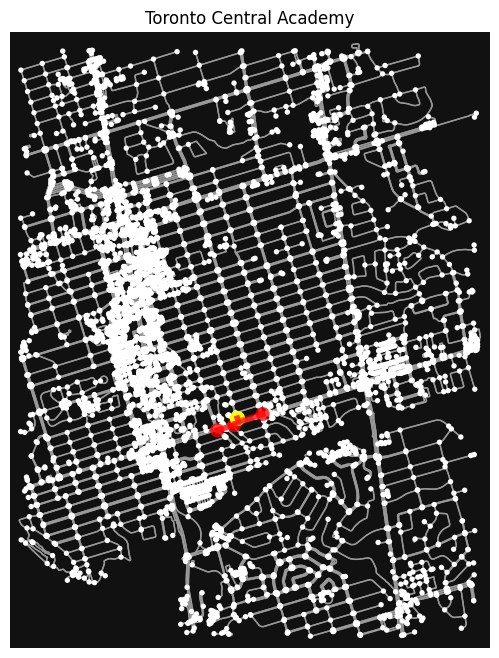

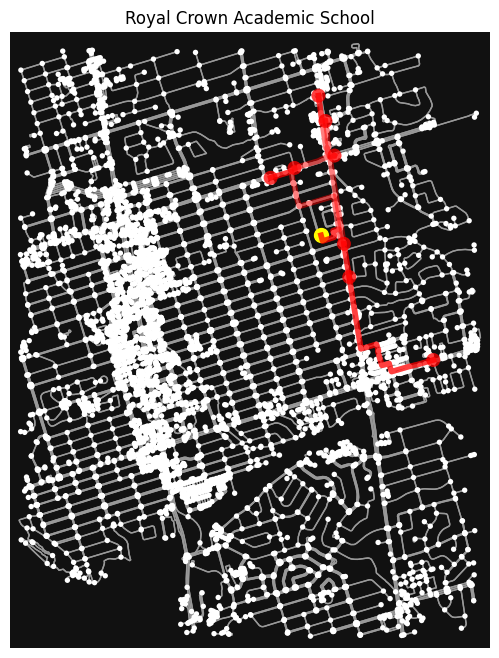

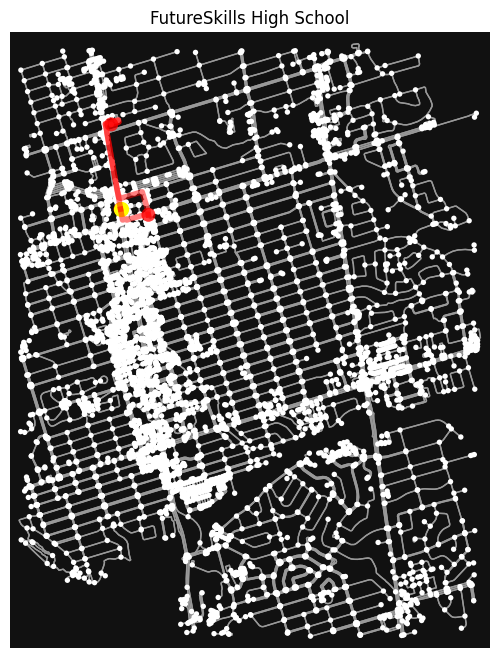

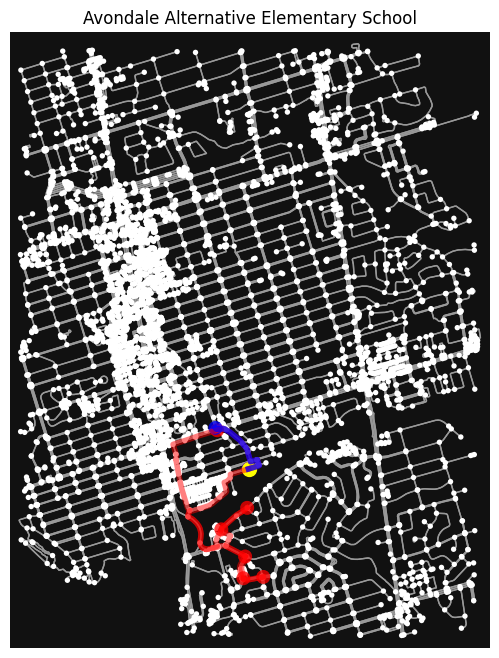

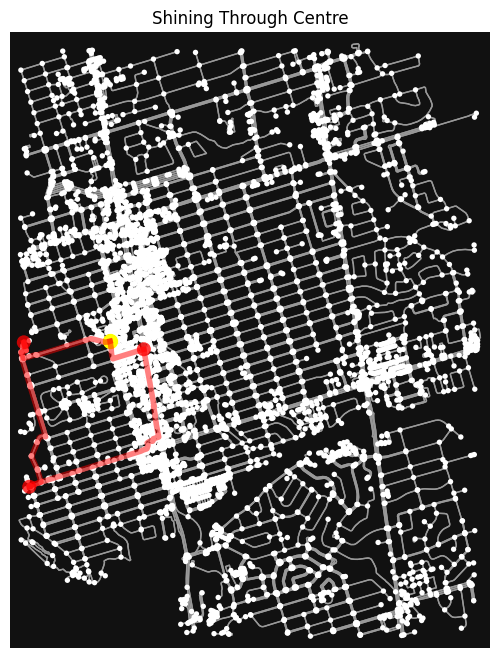

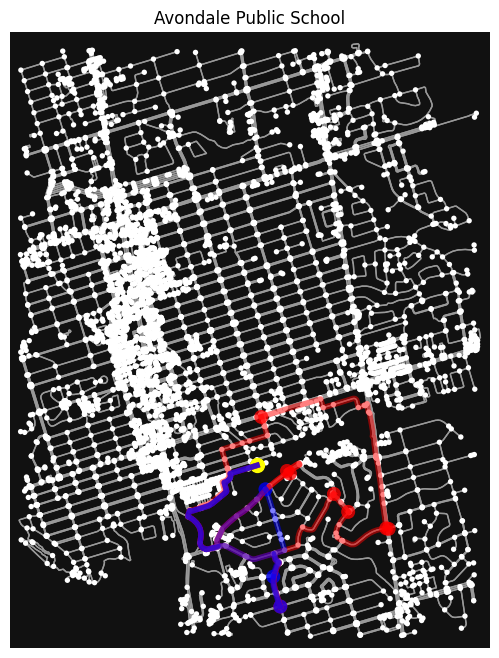

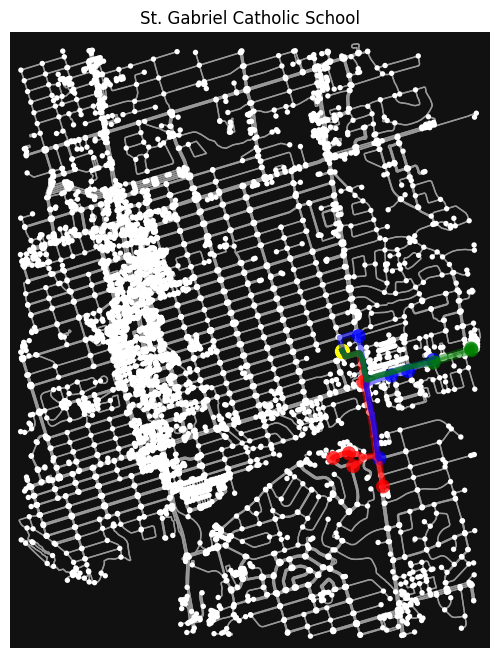

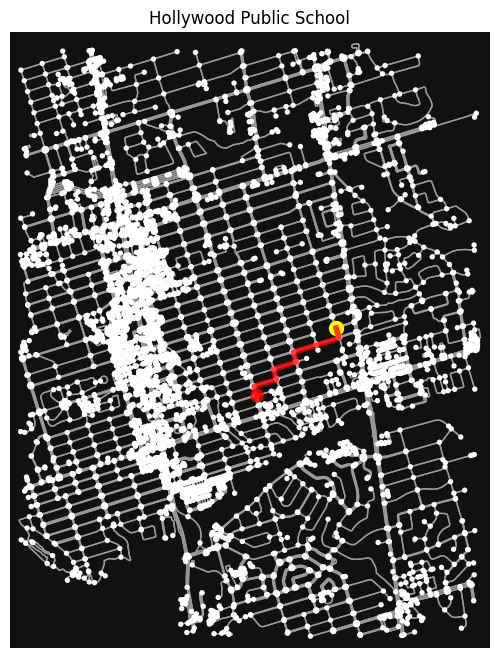

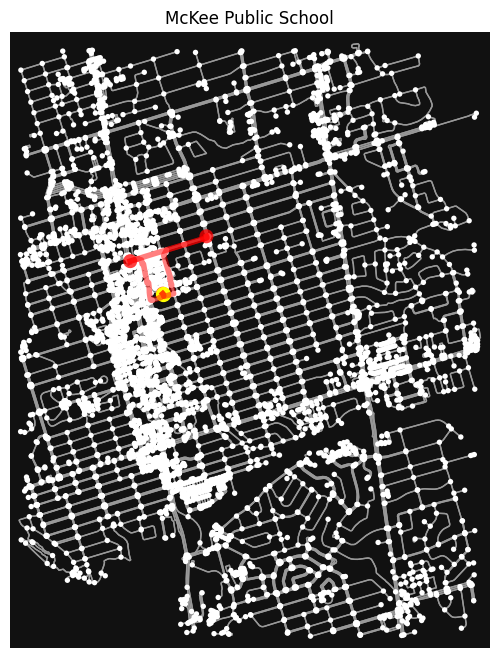

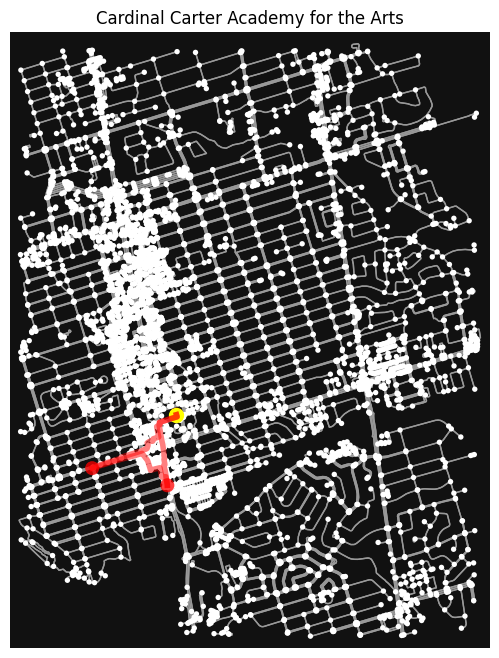

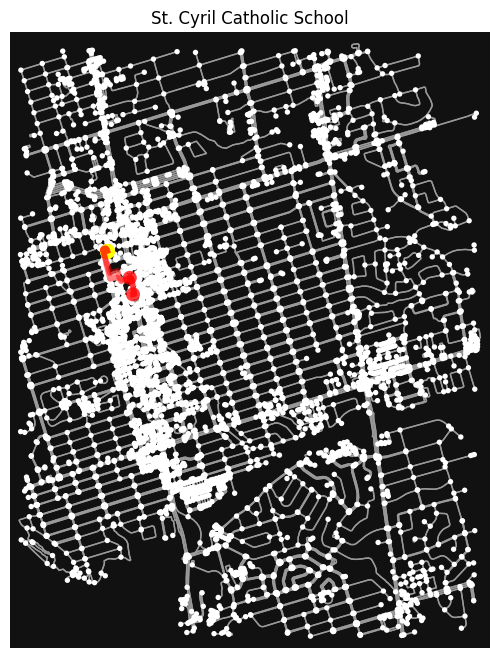

In [ ]:
colors = ['r', 'b', 'g', 'cyan']
for path in found_path_som:
  if len(path) != 0:
    # One figure per school
    fig, ax = ox.plot_graph(graph, show=False, close=False)
    for sub_path_index in range(len(path)):
      print(path[sub_path_index])
      nearest_nodes = find_nearest_node(graph, path[sub_path_index])
      i = 0
      for i in range(len(nearest_nodes)-1):
        unrelaxed_nodes = [Node(graph, osmid) for osmid in graph.nodes()]
        origin = Node(graph=graph, osmid=nearest_nodes[i])
        destination = Node(graph=graph, osmid=nearest_nodes[i+1])
        solution_Dijkstra = Dijkstra(origin, destination, unrelaxed_nodes)
        # Different bus routes from the same school are with different colors
        ox.plot_graph_route(graph, solution_Dijkstra.result, route_color=colors[sub_path_index], orig_dest_size=100, ax=ax, show=False, close=False)
    # mark the start point (school) with yellow
    ax.scatter(graph.nodes[nearest_nodes[0]]['x'], graph.nodes[nearest_nodes[0]]['y'], c='yellow', s=100)
    ax.set_title(path[0][0])